# SPX Volatility Term Structure Analysis

In this exercise we analyze the SPX volatility structure based on daily close prices over the period of 1970-2018. We rely on the Black-Scholes framework and the Dupire formula to calibrate our volatility curve parameters to fit the historical SPX return distribution. Click [here](https://github.com/jackliu234/spx-vol-term-struct/blob/master/project-lab.ipynb) to download this notebook. 

## Section 1: Theoretical Discussion

We start off by assuming that the local volatility is a function of the log-in-the-moneyness $x$ for a fixed maturity window of $T$ business days.

$$ \sigma(x) = g(x) \\
\text{ where } x=log(K/S_0)$$

Under the Black-Scholes framework with risk-free rate $r=0$, a call option premium for $S_0=1$ is: 

$$ C(K, T) = \Phi(d1) - K\Phi(d2) \\
d_{\text{1, 2}} = \dfrac{log(1/K) \pm (\sigma^2/2)T}{\sigma\sqrt{T}} $$ 

If we assume that there exists a probability density function $f_{S_T}$, we have: 

$$ C(K, T) = \int^{\infty}_K(S_T-K)f_{S_T}(S_T)dS_T $$ 

Taking partial derivative w.r.t. $K$, we get the Dupire formula: 

$$ \dfrac{\partial C}{\partial K} = \int^{\infty}_K -f_{S_T}(S_T)dS_T \\ 
\dfrac{\partial^2 C}{\partial K^2} = f_{S_T}(K) $$

We can approximate the second-order derivative numerically: 

$$ f_{S_T}(K) \approx \dfrac{C(K + \Delta K) - 2C(K) + C(K - \Delta K)}{(\Delta K)^2} $$

We previously defined that $x = log(K)$. Given any $\Delta K$, let us define $\Delta x$ such that:

$$ \Delta x = \dfrac{\Delta K}{K} \\
\text{therefore, } \Delta K = e^{x}\Delta x $$ 

We define $r_T$ as the $T$ period log return, and that $r_T=log(S_T)$. Based on chain rule:
    
$$ f_{r_T}(x) = f_{S_T}(K) \times K $$

So in conclusion we have: 
    
$$ f_{r_T}(x) = f_{S_T}(K) \times K \approx \dfrac{C(e^x + e^x\Delta x) - 2C(e^x) + C(e^x - e^x\Delta x)}{e^x(\Delta x)^2} \\
\text{where } C(x) = \Phi(\dfrac{-x + (\sigma(x)^2/2)T}{\sigma(x)\sqrt{T}}) - e^x\Phi(\dfrac{-x - (\sigma(x)^2/2)T}{\sigma(x)\sqrt{T}}) \text{, and } \sigma(x) = g(x) $$

The goal is to find the optimal volatility function $g(x)$ such that $f_{r_T}(x)$ is close to the historical distribution of $r_T$, in terms of squared Euclidean distance.

## Section 2: Python Code

### Part 1: Import Packages

In [1]:
import sys
import time
import json
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits import mplot3d
from urllib.request import urlopen
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
warnings.filterwarnings('ignore')

### Part 2: Declare Functions

In [159]:
def yahoo_parser(url):
    response = urlopen(url)
    data = json.loads(response.read().decode("utf-8"))['chart']['result'][0]
    t = pd.to_datetime(data['timestamp'], unit='s').date
    c = data['indicators']['quote'][0]['close']
    return pd.DataFrame({'close': c}, index=t)


def default_parser(url):
    return pd.read_csv(url, index_col=0, parse_dates=True)


def retrieve(source, code, label, column=None):
    query = {
        'yahoo': 'https://query1.finance.yahoo.com/v8/finance/chart/{}?period1=0&period2=5000000000&interval=1d',
    }
    parser = {
        'yahoo': yahoo_parser,
    }
    url = query.get(source).format(code)
    df = parser.get(source, default_parser)(url)
    df.index.name = None
    df.columns = [col.lower() for col in df.columns] if df.shape[1] > 1 else [label]
    if not column: column = df.columns
    all_dates = pd.date_range(df.index.min(), df.index.max(), freq='D')
    df = df.replace('.', None).reindex(all_dates).fillna(method='ffill')
    return df.astype('float')[column].squeeze()


def sigma_func_linear(x, a, b):
    return a * x + b


def sigma_func_quad(x, a, b, c):
    return a * x**2 + b * x + c


def sigma_func_diff_quad(x, a1, a2, b, c):
    return a1 * x**2 * (x >= 0) + a2 * x**2 * (x < 0) + b * x + c


def calc_call_premium(K, T, sigma): 
    if sigma == 0:
        return 1 - K;
    else:
        d1 = (np.log(1/K) + sigma**2 / 2 * T)/(sigma * np.sqrt(T))
        d2 = (np.log(1/K) - sigma**2 / 2 * T)/(sigma * np.sqrt(T))
        c = norm.cdf(d1) - K * norm.cdf(d2)
        return c


def calc_density(x, r, T, sigma, delta_x):
    f = np.exp(r * T) * (calc_call_premium(np.exp(x) * (1 + delta_x), T, sigma)
                       - 2 * calc_call_premium(np.exp(x), T, sigma) 
                       + calc_call_premium(np.exp(x) * (1 - delta_x), T, sigma)) / (np.exp(x) * delta_x**2)
    return f



def obj_func(params, r_series, term_day, kde, method):
    """
    :param params: one-dimension vector/list,
                    if linear, np.array([intercept, beta_1]);
                    if quad, np.array([intercept, beta_1, beta_2])
    :param r_series: pd.Series, of return / log(K/S0), of which we should calculate the prob density
    :param term_day: days to maturity of option
    :param kde: sklearn.neighbors.KernelDensity
    :param method: 'linear' / 'quad', otherwise raise Error
    
    :return: float
        Mean of Squared Errors
        Why use mean instead of sum: reduce the value of obj_func so that the solver is less sensitive
    """
    kde.fit(np.reshape(r_series.values, (-1, 1)))
    avg, std = r_series.mean(), r_series.std()
    r_sample = (np.arange(avg-3*std, avg+3*std, 0.05*std)).reshape(-1, 1)
    density_true = (np.exp(kde.score_samples(r_sample))).reshape(-1, 1)
    if method == 'linear' and len(params) == 2:
        density_pred = [calc_density(elem, r=0, T=term_day/260, 
                                     sigma=sigma_func_linear(elem, params[0], params[1]),
                                     delta_x=0.01) for elem in r_sample]
    elif method == 'quad' and len(params) == 3:
        density_pred = [calc_density(elem, r=0, T=term_day/260, 
                                     sigma=sigma_func_quad(elem, params[0], params[1], params[2]), 
                                     delta_x=0.01) for elem in r_sample]
    else:
        raise Exception("Wrong param dimension or fit method!")
    sse = ((density_true - density_pred) ** 2).mean()
    return sse

def plot_vol(x, y, terms):
    z = []
    for k, v in terms.items():
        for i in range(len(test['r'])):
            z.append(test['vol_un_quad_fit_' + k][i])
    return np.array(z)

# def obj_func_log_likelihood(params, r_series, term_day, method, curv_diff=False):
#     x_sample = r_series.dropna().values.tolist()
#     result = 0
#     if method == 'linear' and len(params) == 2:
#         for elem in x_sample:
#             result += np.log(calc_density(elem, r=0, T=term_day/260, 
#                                           sigma=sigma_func_linear(elem, params[0], params[1]), 
#                                           delta_x=0.001))
#     elif method == 'quad':
#         if curv_diff and len(params) == 4:
#             for elem in x_sample:
#                 result += np.log(calc_density(elem, r=0, T=term_day/260, 
#                                               sigma=sigma_func_diff_quad(elem, params[0], params[1], params[2], params[3]),
#                                               delta_x=0.001))
#         elif (not curv_diff) and len(params) == 3:
#             for elem in x_sample:
#                 result += np.log(calc_density(elem, r=0, T=term_day/260, 
#                                               sigma=sigma_func_quad(elem, params[0], params[1], params[2]),
#                                               delta_x=0.001))
#         else:
#             raise Exception("Wrong param dimension or fit method!")
#     else:
#         raise Exception("Wrong param dimension or fit method!")
#     return - result


def obj_func_log_likelihood(params, x, term_day, method, curv_diff=False):
    delta_x=0.01
    r=0
    T=term_day/260
    if method == 'linear' and len(params) == 2:
        sigma=x* params[0]+ params[1]
    elif method == 'quad':
        if curv_diff and len(params) == 4:
            sigma= x**3*params[0]+x**2*params[1]+x*params[2]+ params[3]
        elif (not curv_diff) and len(params) == 3:
            sigma= x**2*params[0]+x**1 *params[1]+params[2]
        else:
            raise Exception("Wrong param dimension or fit method!")
    else:
        raise Exception("Wrong param dimension or fit method!")
        
    f = np.exp(r * T) * (calc_call_premium(np.exp(x) * (1 + delta_x), T, sigma)
               - 2 * calc_call_premium(np.exp(x), T, sigma) 
               + calc_call_premium(np.exp(x) * (1 - delta_x), T, sigma)) / (np.exp(x) * delta_x**2)
    result = np.log(f)
    return - result.sum()


def obj_func_likelihood(params, r_series, term_day, method):
    x_sample = r_series.dropna().values.tolist()
    result = 1
    if method == 'linear' and len(params) == 2:
        for elem in x_sample:
            result *= calc_density(elem, r=0, T=term_day/260, sigma=sigma_func_linear(elem, params[0], params[1]),
                                   delta_x=0.001)
    elif method == 'quad':
        if curv_diff and len(params) == 4:
            for elem in x_sample:
                result *= calc_density(elem, r=0, T=term_day/260,
                                       sigma=sigma_func_diff_quad(elem, params[0], params[1], params[2], params[3]),
                                       delta_x=0.001)
        elif (not curv_diff) and len(params) == 3:
            for elem in x_sample:
                result *= calc_density(elem, r=0, T=term_day/260, 
                                      sigma=sigma_func_quad(elem, params[0], params[1], params[2]),
                                      delta_x=0.001)
    else:
        raise Exception("Wrong param dimension or fit method!")
    return - np.log(result)


def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

### Part 3: Format Data

In [4]:
# load yahoo data
raw_df = retrieve('yahoo', '^GSPC', 'SPX').to_frame()


,SPX
1970-01-02,93.000000
1970-01-03,93.000000
1970-01-04,93.000000
1970-01-05,93.459999
1970-01-06,92.820000
1970-01-07,92.629997
1970-01-08,92.680000
1970-01-09,92.400002
1970-01-10,92.400002
1970-01-11,92.400002


In [ ]:
raw_df

In [5]:
# remove all weekends
df = raw_df.copy()
df = df.reindex(pd.date_range(start="1970-01-02", end="2018-12-31", freq='B'))

# take the log price and return
df['log_SPX'] = np.log(df["SPX"])
df['r'] = df['log_SPX'] - df['log_SPX'].shift(1)
df['r_ann'] = df['r'] * 252

term_days = [5, 10] + list(range(20, 521, 20))
term_name = [str(i) + "D" for i in term_days]
terms = dict(zip(term_name, term_days))

# calculate rolling volatilities
for k, v in terms.items(): 
    df['mean_'+ k ] = df["r"].rolling(v).sum()

# remove na
# df.fillna(value=0, inplace=True)

In [6]:
df

,SPX,log_SPX,r,r_ann,mean_5D,mean_10D,mean_20D,mean_40D,mean_60D,mean_80D,...,mean_340D,mean_360D,mean_380D,mean_400D,mean_420D,mean_440D,mean_460D,mean_480D,mean_500D,mean_520D
1970-01-02,93.000000,4.532599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,93.459999,4.537534,0.004934,1.243377,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-06,92.820000,4.530662,-0.006871,-1.731592,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-07,92.629997,4.528613,-0.002049,-0.516372,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-08,92.680000,4.529153,0.000540,0.135997,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-09,92.400002,4.526127,-0.003026,-0.762478,-0.006472,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-12,91.699997,4.518522,-0.007605,-1.916372,-0.019011,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-13,91.919998,4.520919,0.002396,0.603859,-0.009744,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-14,91.650002,4.517977,-0.002942,-0.741289,-0.010636,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-15,91.680000,4.518304,0.000327,0.082471,-0.010848,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
np.mean(df)

SPX          776.934755
log_SPX        6.116116
r              0.000258
r_ann          0.064951
mean_5D        0.001282
mean_10D       0.002569
mean_20D       0.005230
mean_40D       0.010643
mean_60D       0.016055
mean_80D       0.021595
mean_100D      0.027309
mean_120D      0.033082
mean_140D      0.038855
mean_160D      0.044579
mean_180D      0.050219
mean_200D      0.055794
mean_220D      0.061421
mean_240D      0.067043
mean_260D      0.072627
mean_280D      0.078107
mean_300D      0.083500
mean_320D      0.088853
mean_340D      0.094147
mean_360D      0.099405
mean_380D      0.104730
mean_400D      0.110069
mean_420D      0.115465
mean_440D      0.120802
mean_460D      0.126139
mean_480D      0.131553
mean_500D      0.137016
mean_520D      0.142345
dtype: float64

### Part 4: Data Visualization

Time series plot.

In [8]:
cmap = ['#ff0000', '#ff7a00', '#f6ad48', '#c4c6bd', '#3193d8', '#005684']

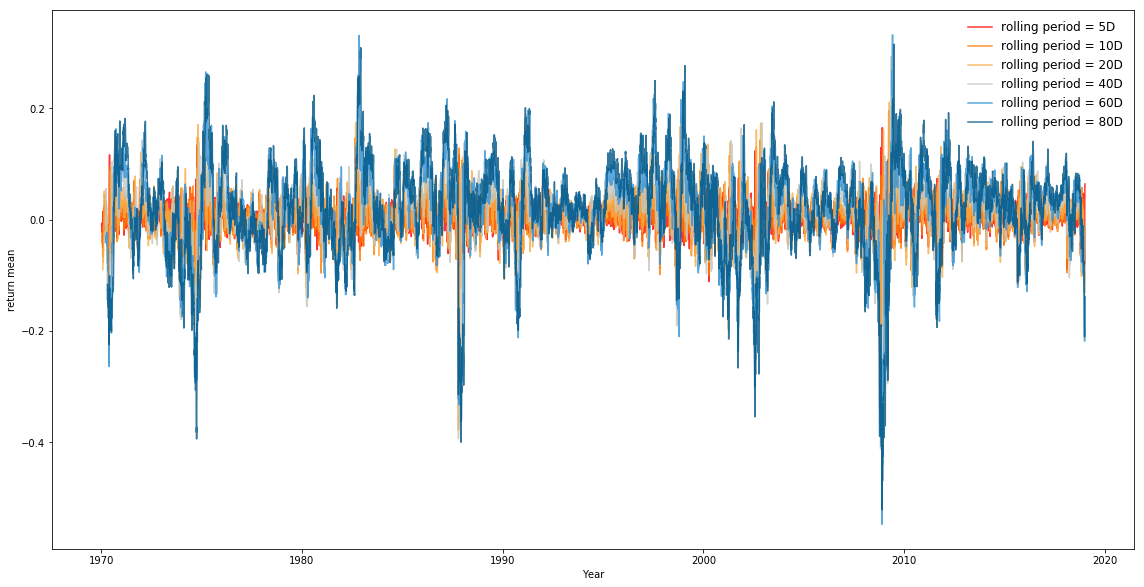

In [9]:
# too many windows, only display six
fig = plt.figure(figsize=(16, 32))
index = 1
for moment in ['mean']: 
    ax = fig.add_subplot(4, 1, index)
    cint = 0
    for term in terms.keys():
        ax.plot(df[moment+"_"+term], color=cmap[cint], label='rolling period = '+term, alpha=.8)
        cint += 1
        if cint==6:
            break
    plt.xlabel('Year')
    plt.ylabel('return '+moment)
    plt.legend(frameon=False, prop={'size': 12})
    plt.tight_layout()
    index += 1

Return distribution.

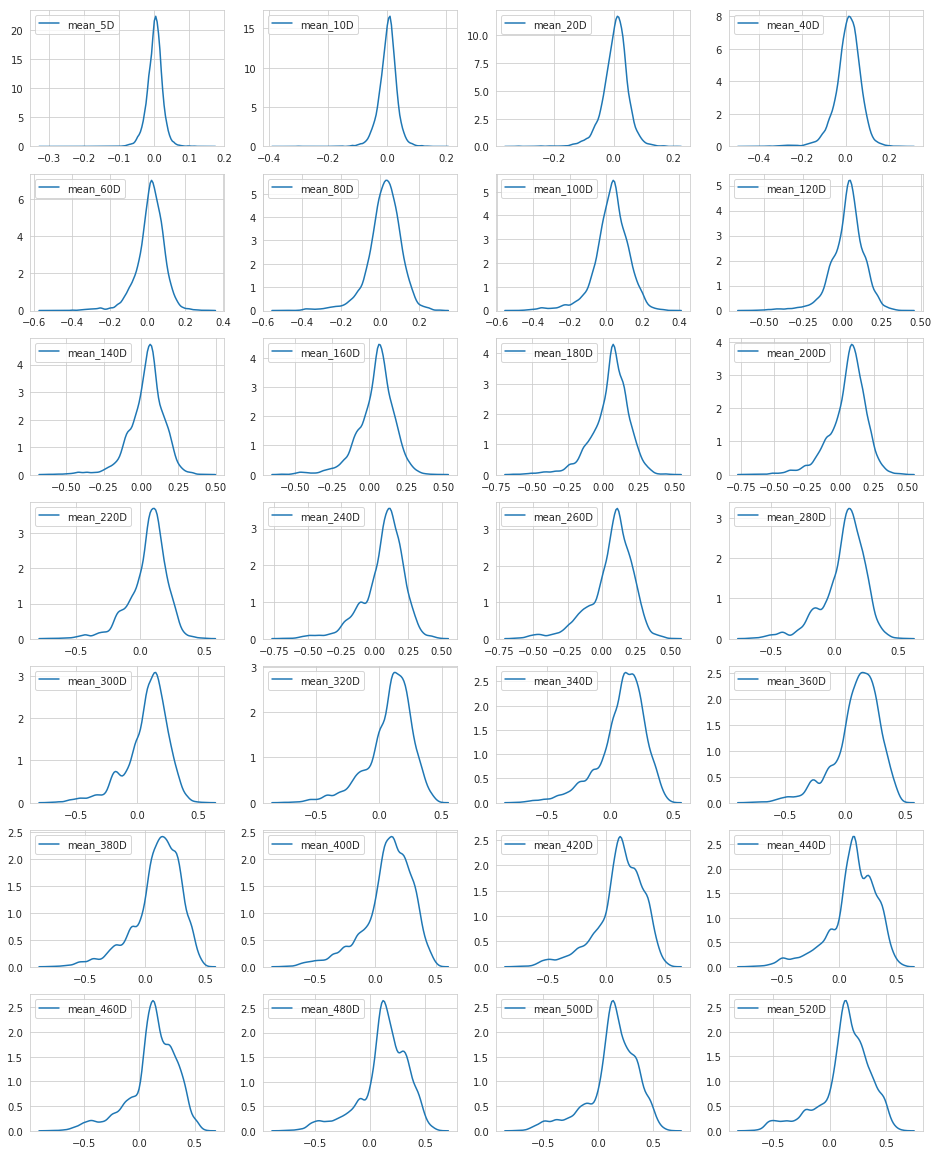

In [10]:
num_window = len(terms)
sns.set_style('whitegrid')
fig = plt.figure(figsize=(16, num_window*3))

index = 1
for term in terms:
    for i in ['mean_']:
        plt.subplot(num_window, 4, index)
        sns.kdeplot(df[i+term])
        index += 1

### Part 5: Fitting Volatility Function - Least Sequare Method

Empirical distribution for window size 20D.

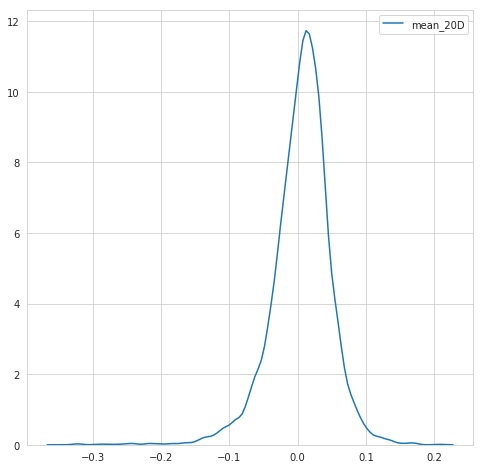

In [11]:
fig = plt.figure(figsize=(8, 8))
sns.kdeplot(df["mean_20D"])

Choose optimal kernel bandwidth.

In [12]:
# pick sample data points for fitting
avg, std = df["mean_20D"].mean(), df["mean_20D"].std()
r_sample = [round(elem, 4) for elem in np.arange(avg - 5 * std, avg + 5 * std, 0.2 * std)]
test = pd.DataFrame(r_sample, columns=['r'])

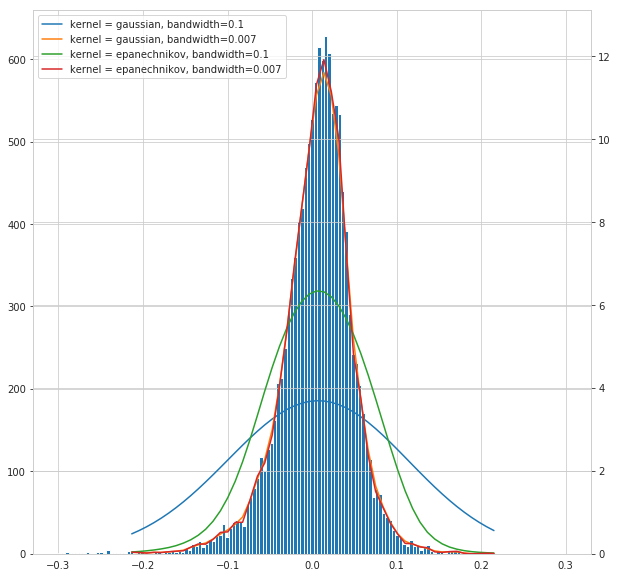

In [119]:
# optimal bandwidth suggested by wiki
n_20D=df.mean_20D.count()
bandwidth=round(1.06 * std * (n_20D)**(-0.2), 4)

fig, ax = plt.subplots(figsize=(10, 10))
bins=np.linspace(-0.3,0.3,150)
ax.hist(df.mean_20D,bins=bins)
ax1 = ax.twinx()
for kernel in ['gaussian', 'epanechnikov']:
    for b in [0.1, bandwidth]:
        kde = KernelDensity(kernel=kernel, bandwidth=b).fit(df[['mean_20D']].dropna())
        log_dens = kde.score_samples(test[['r']])
        ax1.plot(test.r, np.exp(log_dens), '-',
                label="kernel = {}, bandwidth={}".format(kernel, b))
        
align_yaxis(ax, 0, ax1, 0)        
plt.legend(loc="upper left")
plt.show()

In [109]:
# calculate the kde density of the data points
kde = KernelDensity(bandwidth = bandwidth) # larger the bandwidth, smoother the curve
kde.fit(df[['mean_20D']].dropna())
test['f_r'] = [round(elem, 4) for elem in np.exp(kde.score_samples(test[['r']]))]
test.tail()

,r,f_r,f_r_un_linear_fit,f_r_un_quad_fit,vol_un_linear_fit,vol_un_quad_fit,vol_un_quad_fit_5D,vol_un_quad_fit_10D,vol_un_quad_fit_20D,vol_un_quad_fit_40D,...,vol_un_quad_fit_380D,vol_un_quad_fit_400D,vol_un_quad_fit_420D,vol_un_quad_fit_440D,vol_un_quad_fit_460D,vol_un_quad_fit_480D,vol_un_quad_fit_500D,vol_un_quad_fit_520D,f_r_un_quad_diff_fit,vol_un_quad_diff_fit
45,0.1801,0.0193,0.0001,0.0003,0.137192,0.142687,0.089278,0.447771,0.465816,0.409907,...,0.143489,0.140610,0.137759,0.135233,0.133045,0.131292,0.130682,0.130175,0.6564,1.820379
46,0.1888,0.0036,0.0001,0.0001,0.137297,0.143372,0.086797,0.445417,0.479934,0.430016,...,0.146921,0.143630,0.140416,0.137549,0.135068,0.132966,0.132003,0.131151,0.5971,1.990328
47,0.1976,0.0059,0.0000,0.0001,0.137403,0.144094,0.084378,0.443191,0.495164,0.451674,...,0.151085,0.147354,0.143754,0.140525,0.137737,0.135267,0.133930,0.132717,0.5438,2.170021
48,0.2063,0.0109,0.0000,0.0000,0.137507,0.144835,0.082079,0.441141,0.511159,0.474390,...,0.155887,0.151696,0.147695,0.144093,0.140990,0.138142,0.136420,0.134837,0.4968,2.355373
49,0.2151,0.0075,0.0000,0.0000,0.137614,0.145613,0.079845,0.439222,0.528288,0.498685,...,0.161437,0.156758,0.152331,0.148335,0.144902,0.141658,0.139530,0.137560,0.4542,2.550646


#### Grid Search

In [18]:
# result = pd.DataFrame(columns=['method', 'a', 'b', 'c', 'sse'])

In [19]:
# start_t = time.time()
# linear_search_range = np.arange(-5, 5.1, 0.1)
# for a in linear_search_range:
#     for b in linear_search_range:
        
#         test['f_r_calc'] = list(map(lambda elem:round(calc_density(x=elem, r=0, T=20/260, sigma=sigma_func_linear(elem, a, b), delta_x=0.01), 4), test['r']))     
#         test['sse'] = round((test['f_r_calc'] - test['f_r'])**2, 4)
#         result = result.append({'method': 'linear',
#                                 'a': round(a, 4),
#                                 'b': round(b, 4),
#                                 'c': 0,
#                                 'sse': round(np.sum(test['sse']), 4)}, ignore_index=True)
# end_t = time.time()
# print("run time:", round((end_t-start_t)/60, 2), "minute")

In [20]:
# grid_linear_a = result.sort_values(by=['sse']).iloc[0, 1]
# grid_linear_b = result.sort_values(by=['sse']).iloc[0, 2]
# result.sort_values(by=['sse']).head()

In [21]:
# start_t = time.time()
# quad_search_range = np.arange(-5, 5.1, 0.5)
# for a in quad_search_range:
#     for b in quad_search_range:
#         for c in quad_search_range:

#             test['f_r_calc'] = list(map(lambda elem:round(calc_density(x=elem, r=0, T=20/260, sigma=sigma_func_quad(elem, a, b), delta_x=0.01), 4), test['r']))     
#             test['sse'] = round((test['f_r_calc'] - test['f_r'])**2, 4)
#             result = result.append({'method': 'quad',
#                                     'a': round(a, 4),
#                                     'b': round(b, 4),
#                                     'c': round(c, 4),
#                                     'sse': round(np.sum(test['sse']), 4)}, ignore_index=True)
# end_t = time.time()
# print("run time:", round((end_t-start_t)/60, 2), "minute")

In [22]:
# grid_quad_a = result.sort_values(by=['sse']).iloc[0, 1]
# grid_quad_b = result.sort_values(by=['sse']).iloc[0, 2]
# grid_quad_c = result.sort_values(by=['sse']).iloc[0, 3]
# result.sort_values(by=['sse']).head()

In [ ]:
# test['f_r_grid_linear_fit'] = [round(calc_density(x=elem, r=0, T=20/260, sigma=sigma_func_linear(elem, grid_linear_a, grid_linear_b), delta_x=0.01), 4) for elem in test['r']]
# test['f_r_grid_quad_fit'] = [round(calc_density(x=elem, r=0, T=20/260, sigma=sigma_func_quad(elem, grid_quad_a, grid_quad_b, grid_quad_c), delta_x=0.01), 4) for elem in test['r']]

# fig = plt.figure(figsize=(8, 8))
# plt.plot(test['r'], test['f_r'])
# plt.plot(test['r'], test['f_r_grid_linear_fit'])
# plt.plot(test['r'], test['f_r_grid_quad_fit'])
# plt.legend()

In [ ]:
# test['vol_grid_linear_fit'] = [sigma_func_linear(elem, grid_linear_a, grid_linear_b) for elem in test['r']]
# test['vol_grid_quad_fit'] = [sigma_func_quad(elem, grid_quad_a, grid_quad_b, grid_quad_c) for elem in test['r']]

# plt.plot(test['r'], test['vol_grid_linear_fit'])
# plt.plot(test['r'], test['vol_grid_quad_fit'])
# plt.legend()
# plt.xlabel('return')
# plt.ylabel('volatility')

#### Scipy Optimization

In [110]:
# linear volatility function
start_t = time.time()
r_series = df['mean_20D'].dropna()
term_day = 20
kde = KernelDensity(bandwidth=bandwidth)
method = 'linear'
obj_min = minimize(obj_func, (-1, 1), args=(r_series, term_day, kde, method), method='SLSQP')
end_t = time.time()
un_linear_a, un_linear_b = obj_min.x
print("run time:", round((end_t-start_t)/60, 2), "minute")
obj_min

run time: 0.28 minute


     fun: 1.4778174601686418
     jac: array([-2.62260437e-06,  8.03112984e-04])
 message: 'Optimization terminated successfully.'
    nfev: 38
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.01205079, 0.1350214 ])

In [111]:
# quadratic volatility function
start_t = time.time()
r_series = df['mean_20D'].dropna()
term_day = 20
kde = KernelDensity(bandwidth=bandwidth)
method = 'quad'
obj_min = minimize(obj_func, (1, -1, 1), args=(r_series, term_day, kde, method), method='SLSQP')
end_t = time.time()
un_quad_a, un_quad_b, un_quad_c = obj_min.x
print("run time:", round((end_t-start_t)/60, 2), "minute")
obj_min

run time: 0.36 minute


     fun: 1.477607767586312
     jac: array([-2.01761723e-05,  2.92807817e-05,  8.22049379e-03])
 message: 'Optimization terminated successfully.'
    nfev: 66
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.18429021, 0.01074919, 0.1347739 ])

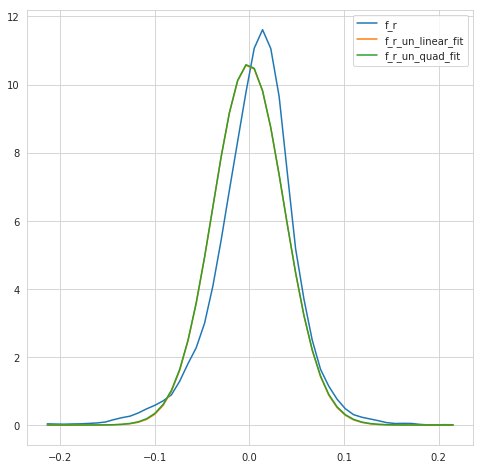

In [112]:
test['f_r_un_linear_fit'] = [round(calc_density(x=elem, r=0, T=20/260, sigma=sigma_func_linear(elem, un_linear_a, un_linear_b), delta_x=0.01), 4) for elem in test['r']]
test['f_r_un_quad_fit'] = [round(calc_density(x=elem, r=0, T=20/260, sigma=sigma_func_quad(elem, un_quad_a, un_quad_b, un_quad_c), delta_x=0.01), 4) for elem in test['r']]

fig = plt.figure(figsize=(8, 8))
plt.plot(test['r'], test['f_r'])
plt.plot(test['r'], test['f_r_un_linear_fit'])
plt.plot(test['r'], test['f_r_un_quad_fit'])
plt.legend()

Text(0, 0.5, 'volatility')

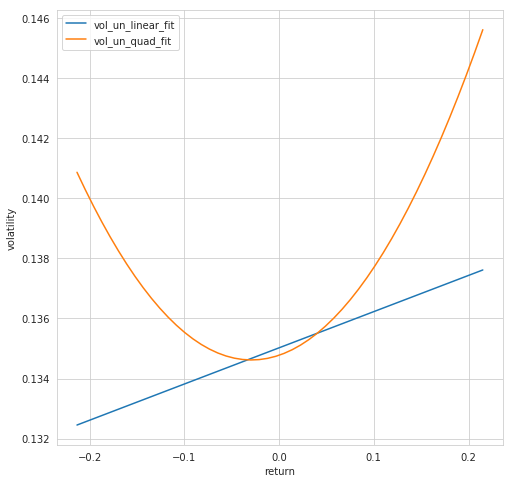

In [113]:
test['vol_un_linear_fit'] = [sigma_func_linear(elem, un_linear_a, un_linear_b) for elem in test['r']]
test['vol_un_quad_fit'] = [sigma_func_quad(elem, un_quad_a, un_quad_b, un_quad_c) for elem in test['r']]

fig = plt.figure(figsize=(8, 8))
plt.plot(test['r'], test['vol_un_linear_fit'])
plt.plot(test['r'], test['vol_un_quad_fit'])
plt.legend()
plt.xlabel('return')
plt.ylabel('volatility')

#### Construct Volatility Surface

Base on performance above, we chose to use the **unbounded scipy optimization** with **quadratic volatility function** to construct the volatility term curve.

In [66]:
curve = pd.DataFrame(columns=['term', 'a', 'b', 'c'])
for k, v in terms.items(): 
    r_series = df['mean_' + k].dropna()
    term_day = v
    kde = KernelDensity(bandwidth=0.1)
    method = 'quad'
    obj_min = minimize(obj_func, (1, -1, 1), args=(r_series, term_day, kde, method), method='SLSQP')
    curve_un_quad_a, curve_un_quad_b, curve_un_quad_c = obj_min.x
    test['vol_un_quad_fit_' + k] = [sigma_func_quad(elem, curve_un_quad_a, curve_un_quad_b, curve_un_quad_c) for elem in test['r']]
    curve = curve.append({'term': v,
                          'a': round(curve_un_quad_a, 4),
                          'b': round(curve_un_quad_b, 4),
                          'c': round(curve_un_quad_c, 4)}, ignore_index=True)

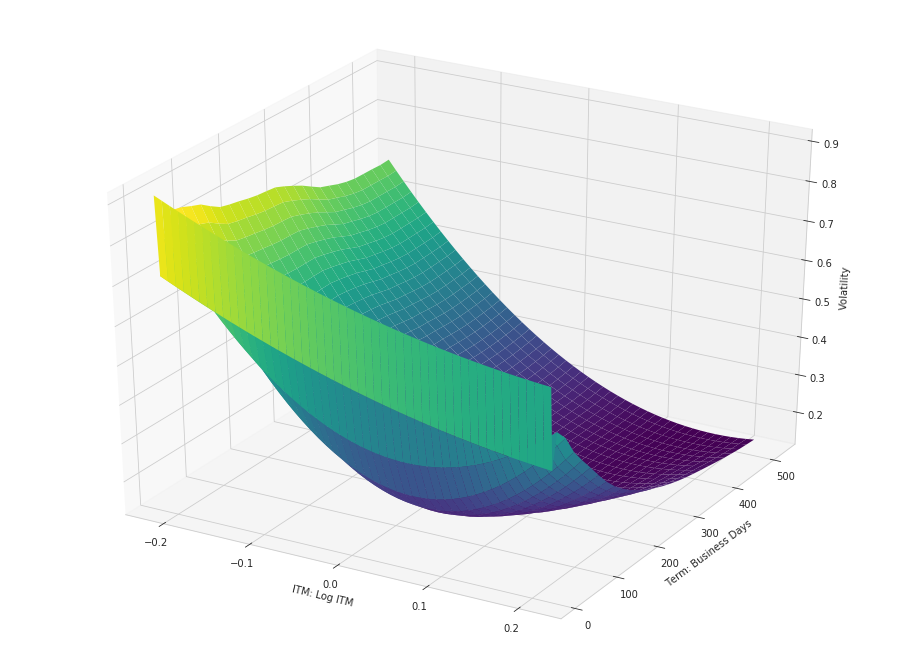

In [67]:
x = test['r']
y = term_days
X, Y = np.meshgrid(x, y)
Z = plot_vol(X, Y).reshape(X.shape)

fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('ITM: Log ITM')
ax.set_ylabel('Term: Business Days')
ax.set_zlabel('Volatility');

Text(0, 0.5, 'Parameters')

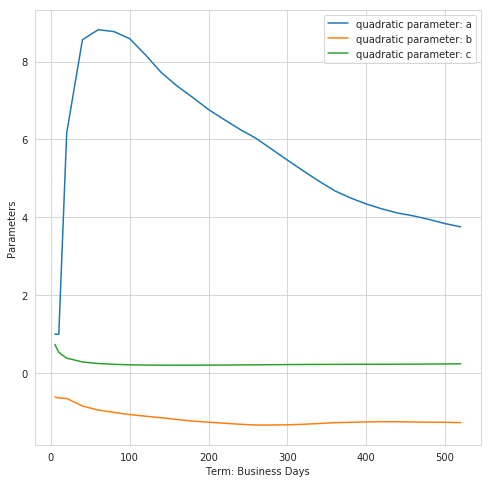

In [68]:
curve.index = curve.term
fig = plt.figure(figsize=(8, 8))
plt.plot(curve.index, curve.a, label='quadratic parameter: a')
plt.plot(curve.index, curve.b, label='quadratic parameter: b')
plt.plot(curve.index, curve.c, label='quadratic parameter: c')
plt.legend()
plt.xlabel('Term: Business Days')
plt.ylabel('Parameters')

### Part 6: Fitting Volatility Function - Maximum Likelihood Estimator

As MLE assumes i.i.d. samples, non-rolling period return should be used in MLE

In [ ]:
# df_nr = df.iloc[::20, :]
# df_nr

#### Linear model

In [114]:
# linear volatility function
start_t = time.time()
full_series = df['mean_20D'].dropna()
term_day = 20
keep_rows = list(range(0, len(full_series), term_day))
r_series = full_series.iloc[keep_rows]
method = 'linear'

obj_MLE = minimize(obj_func_log_likelihood, (-1, 1), args=(r_series, term_day, method), method='SLSQP', options={'disp': True})
end_t = time.time()
MLE_linear_a, MLE_linear_b = obj_MLE.x
print("run time:", round((end_t-start_t)/60, 2), "minute")
obj_MLE

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1048.525666858142
            Iterations: 20
            Function evaluations: 166
            Gradient evaluations: 20
run time: 1.71 minute


     fun: -1048.525666858142
     jac: array([-1856.78009033,  1221.21417236])
 message: 'Optimization terminated successfully.'
    nfev: 166
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([-0.00143991,  0.19911636])

#### Quadratic model - same kurtosis when +/-

In [115]:
# quadratic volatility function
start_t = time.time()
full_series = df['mean_20D'].dropna()
term_day = 20
keep_rows = list(range(0, len(full_series), term_day))
r_series = full_series.iloc[keep_rows]
method = 'quad'

obj_MLE = minimize(obj_func_log_likelihood, (1, -1, 1), args=(r_series, term_day, method, False), method='SLSQP')
end_t = time.time()
MLE_quad_a, MLE_quad_b, MLE_quad_c = obj_MLE.x
print("run time:", round((end_t-start_t)/60, 2), "minute")
obj_MLE

run time: 2.1 minute


     fun: -1457.3009350280051
     jac: array([-0.02253723,  0.09136963, -2.87591553])
 message: 'Optimization terminated successfully.'
    nfev: 213
     nit: 34
    njev: 34
  status: 0
 success: True
       x: array([7.26158088e+01, 7.10889609e-02, 2.68070264e-02])

#### Quadratic model - different kurtosis when +/-

In [116]:
# quadratic volatility function
start_t = time.time()
full_series = df['mean_20D'].dropna()
term_day = 20
keep_rows = list(range(0, len(full_series), term_day))
r_series = full_series.iloc[keep_rows]
method = 'quad'

obj_MLE = minimize(obj_func_log_likelihood, (1, 1, -1, 1), args=(r_series, term_day, method, True), method='SLSQP')
end_t = time.time()
MLE_quad_diff_a1, MLE_quad_diff_a2, MLE_quad_diff_b, MLE_quad_diff_c = obj_MLE.x
print("run time:", round((end_t-start_t)/60, 2), "minute")
obj_MLE

run time: 2.5 minute


     fun: -1445.8650816329118
     jac: array([ 3.90014648e-02,  4.72564697e-02, -9.08355713e-01, -4.06685333e+01])
 message: 'Optimization terminated successfully.'
    nfev: 239
     nit: 34
    njev: 34
  status: 0
 success: True
       x: array([5.05854212e+01, 1.34934089e+02, 8.73400165e-01, 2.22906625e-02])

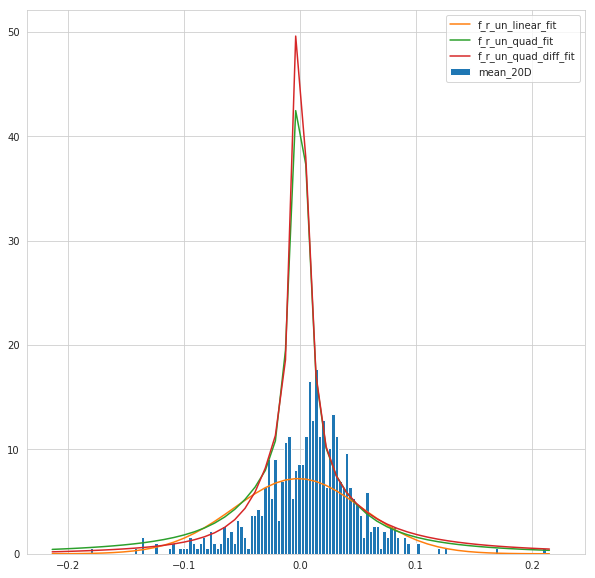

In [117]:
fig, ax = plt.subplots(figsize=(10, 10))
bins=np.linspace(avg - 5 * std, avg + 5 * std, 150)

scale = 100
ax.hist(r_series, bins=bins, density=True)
test['f_r_un_linear_fit'] = [round(calc_density(x=elem, r=0, T=20/260, 
                                                sigma=sigma_func_linear(elem, MLE_linear_a, MLE_linear_b), delta_x=0.01), 4) 
                             for elem in test['r']]
test['f_r_un_quad_fit'] = [round(calc_density(x=elem, r=0, T=20/260, 
                                              sigma=sigma_func_quad(elem, MLE_quad_a, MLE_quad_b, MLE_quad_c),
                                              delta_x=0.01), 4) 
                           for elem in test['r']]
test['f_r_un_quad_diff_fit'] = [round(calc_density(x=elem, r=0, T=20/260, 
                                              sigma=sigma_func_diff_quad(elem, MLE_quad_diff_a1, MLE_quad_diff_a2, 
                                                                    MLE_quad_diff_b, MLE_quad_diff_c),
                                              delta_x=0.01), 4) 
                           for elem in test['r']]

ax.plot(test['r'], test['f_r_un_linear_fit'])
ax.plot(test['r'], test['f_r_un_quad_fit'])
ax.plot(test['r'], test['f_r_un_quad_diff_fit'])
ax.legend()

Text(0, 0.5, 'volatility')

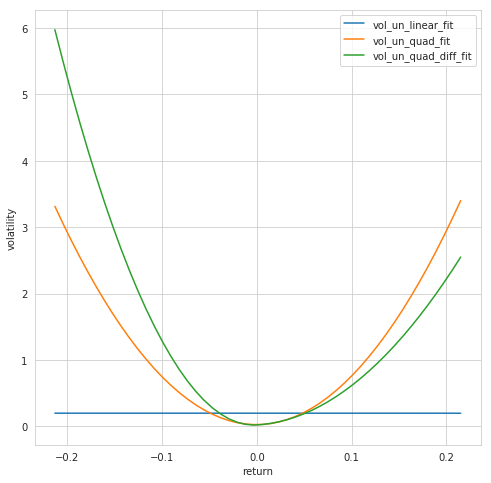

In [118]:
test['vol_un_linear_fit'] = [sigma_func_linear(elem, MLE_linear_a, MLE_linear_b) for elem in test['r']]
test['vol_un_quad_fit'] = [sigma_func_quad(elem, MLE_quad_a, MLE_quad_b, MLE_quad_c) for elem in test['r']]
test['vol_un_quad_diff_fit'] = [sigma_func_diff_quad(elem, MLE_quad_diff_a1, MLE_quad_diff_a2, MLE_quad_diff_b, MLE_quad_diff_c) 
                           for elem in test['r']]

fig = plt.figure(figsize=(8, 8))
plt.plot(test['r'], test['vol_un_linear_fit'])
plt.plot(test['r'], test['vol_un_quad_fit'])
plt.plot(test['r'], test['vol_un_quad_diff_fit'])
plt.legend()
plt.xlabel('return')
plt.ylabel('volatility')

In [120]:
curve = pd.DataFrame(columns=['term', 'a', 'b', 'c'])
for k, v in terms.items(): 
    full_series = df['mean_' + k].dropna()
    term_day = v
    keep_rows = list(range(0, len(full_series), term_day))
    r_series = full_series.iloc[keep_rows]
    method = 'quad'
    obj_MLE = minimize(obj_func_log_likelihood, (1, -1, 1), args=(r_series, term_day, method, False), method='SLSQP')
    curve_un_quad_a, curve_un_quad_b, curve_un_quad_c = obj_MLE.x
    test['vol_un_quad_fit_' + k] = [sigma_func_quad(elem, curve_un_quad_a, curve_un_quad_b, curve_un_quad_c) for elem in test['r']]
    curve = curve.append({'term': v,
                          'a': round(curve_un_quad_a, 4),
                          'b': round(curve_un_quad_b, 4),
                          'c': round(curve_un_quad_c, 4)}, ignore_index=True)

Text(0.5, 0.98, 'volatility surface: all terms')

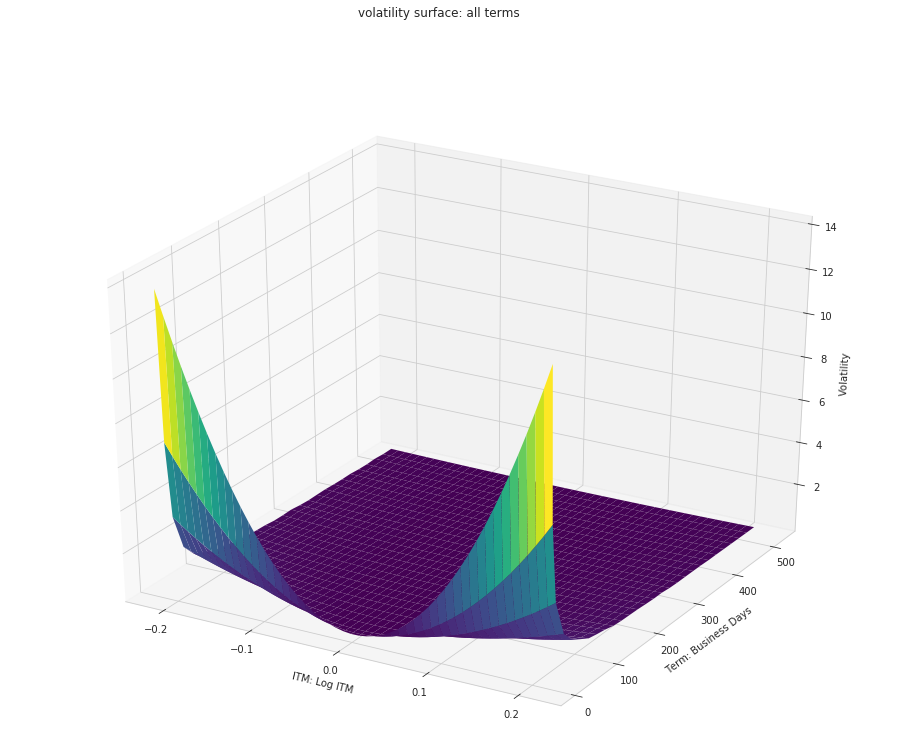

In [156]:
x = test['r']
y = term_days
X, Y = np.meshgrid(x, y)
Z = plot_vol(X, Y, terms).reshape(X.shape)

fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('ITM: Log ITM')
ax.set_ylabel('Term: Business Days')
ax.set_zlabel('Volatility');
fig.suptitle('volatility surface: all terms')

Text(0.5, 0.98, 'volatility surface: term >= 50D')

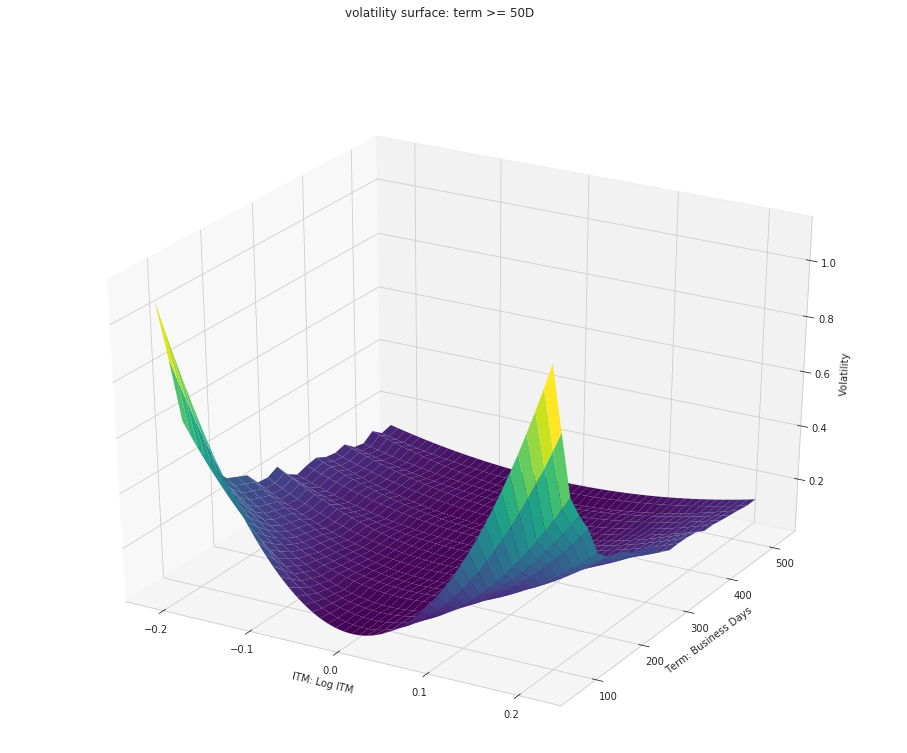

In [154]:
x = test['r']
y = [item for item in term_days if item >= 50]
y_name = [str(i) + "D" for i in y]
y_dict = dict(zip(y_name, y))

X, Y = np.meshgrid(x, y)
Z = plot_vol(X, Y, y_dict).reshape(X.shape)

fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('ITM: Log ITM')
ax.set_ylabel('Term: Business Days')
ax.set_zlabel('Volatility');
fig.suptitle('volatility surface: term >= 50D')

Text(0, 0.5, 'Parameters')

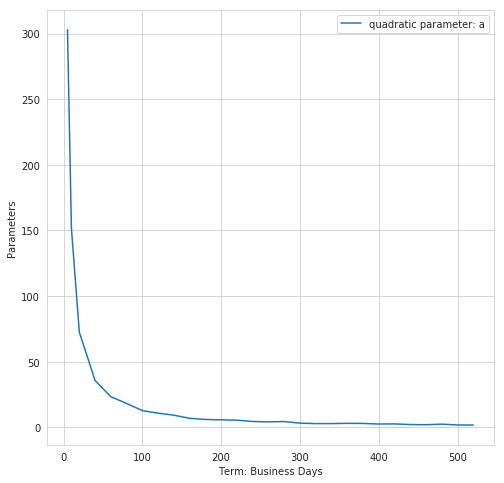

In [158]:
curve.index = curve.term
fig = plt.figure(figsize=(8, 8))
plt.plot(curve.index, curve.a, label='quadratic parameter: a')
plt.legend()
plt.xlabel('Term: Business Days')
plt.ylabel('Parameters')

Text(0, 0.5, 'Parameters')

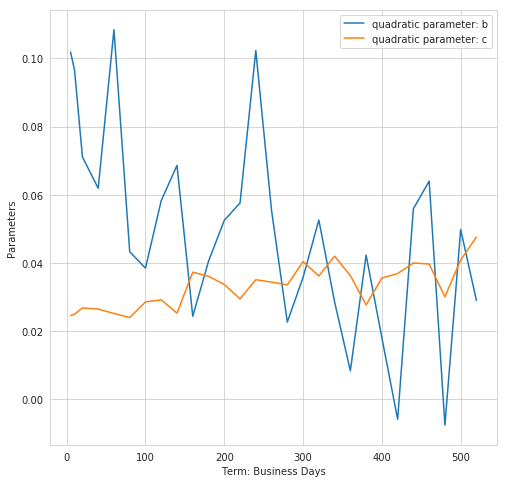

In [157]:
curve.index = curve.term
fig = plt.figure(figsize=(8, 8))
plt.plot(curve.index, curve.b, label='quadratic parameter: b')
plt.plot(curve.index, curve.c, label='quadratic parameter: c')
plt.legend()
plt.xlabel('Term: Business Days')
plt.ylabel('Parameters')

#### Take the average of different MLE to smooth the estimation

In [ ]:
col_names = ['linear_a', 'linear_b', 'quad_a', 'quad_b', 'quad_c', 'quad_diff_a1', 'quad_diff_a2', 'quad_diff_b', 'quad_diff_c']
MLE_20D = pd.DataFrame(columns=col_names)
term_day = 20
for i in range(term_day):
    opt_params = []
    full_series = df['mean_20D'].dropna()
    keep_rows = list(range(i, len(full_series), term_day))
    r_series = full_series.iloc[keep_rows]
    
    # linear volatility function
    start_t = time.time()
    method = 'linear'
    obj_MLE = minimize(obj_func_1, (-1, 1), args=(r_series, term_day, method), method='SLSQP')
    end_t = time.time()
    opt_params.extend(obj_MLE.x)
    print("Task_1" , str(i+1), 'of', str(term_day), "run time:", round((end_t-start_t)/60, 2), "minute......")
    
    # quadratic volatility function, with same kurtosis
    start_t = time.time()
    method = 'quad'
    obj_MLE = minimize(obj_func_log_likelihood, (1, -1, 1), args=(r_series, term_day, method, False), method='SLSQP')
    end_t = time.time()
    opt_params.extend(obj_MLE.x)
    print("Task_2" , str(i+1), 'of', str(term_day), "run time:", round((end_t-start_t)/60, 2), "minute......")
    
    # quadratic volatility function, with different kurtosis
    start_t = time.time()
    obj_MLE = minimize(obj_func_log_likelihood, (1, 1, -1, 1), args=(r_series, term_day, method, True), method='SLSQP')
    end_t = time.time()
    opt_params.extend(obj_MLE.x)
    print("Task_3" , str(i+1), 'of', str(term_day), "run time:", round((end_t-start_t)/60, 2), "minute......")
    tmp = pd.DataFrame([opt_params], columns=col_names, index=[i])
    MLE_20D = pd.concat([MLE_20D, tmp], axis=0)

In [118]:
MLE_20D

,linear_a,linear_b,quad_a,quad_b,quad_c,quad_diff_a1,quad_diff_a2,quad_diff_b,quad_diff_c
0,-0.183294,0.160093,69.541595,0.073301,0.027857,50.458006,132.203609,0.863530,0.022661
1,-0.149153,0.150173,66.383733,0.097704,0.027466,55.367587,117.828214,0.704364,0.021960
2,-0.253116,0.158397,79.256544,0.109239,0.022820,59.231058,119.111389,0.690272,0.020882
3,-0.030302,0.142495,78.159096,0.058300,0.022436,70.957478,99.585358,0.334009,0.020834
4,-0.095119,0.150377,73.993863,0.064214,0.025132,59.248741,123.951375,0.663551,0.021099
5,0.083457,0.114310,1.017749,-0.076946,0.143597,57.489268,112.078608,0.625781,0.023679
6,-0.160857,0.160243,71.149122,0.096485,0.026040,59.584750,115.100846,0.635982,0.021703
7,-0.106001,0.162505,74.585880,0.057514,0.025061,61.773167,111.559794,0.540502,0.022327
8,-0.225640,0.161852,76.117525,0.050871,0.024539,58.168609,121.999007,0.663545,0.021611
9,-0.014992,0.168927,74.846979,0.079151,0.025388,60.168132,116.676108,0.628247,0.022083


#### MLE Optimization

The following computations are based on MLE optimization. Samples in an MLE optimizer are non-rolling period returns. The reason for using non-rolling returns is that: MLE requires different observations to be independent and identically distributed. $N$-day rolling returns are correlated to each other as the closest two observations include return in the same $N-1$ days.


For example,

$S_1, S_2, \cdots, S_{41}$ are daily stock price, a sample set of MLE optimizer would be:
$$\%change(S_{21}, S_1),\%change(S_{41}, S_{21}), \cdots$$


If we denote $x_1, x_2, \cdots, x_{41}$ as a series of 20_D rolling return, then a sample set of MLE optimizer would be:
$$x_1, x_{21}, x_{31}, \cdots$$


Therefore, to fully utilize the data we already have, we can construct 20 different sample sets for a MLE optimizer on 20D data.

Sample 1: $x_1, x_{21}, x_{41}, \cdots$

Sample 2: $x_2, x_{22}, x_{42}, \cdots$

Sample i: $x_i, x_{20+i}, x_{40+i}, \cdots$


We will run the optimization on each set of samples, store the optimal parameters and then use the results to figure out mean, std of parameters, and therefore construct a confidence interval.

In [ ]:
col_names = ['linear_a', 'linear_b', 'quad_a', 'quad_b', 'quad_c', 'quad_diff_a1', 'quad_diff_a2', 'quad_diff_b', 'quad_diff_c']
full_result = pd.DataFrame(columns=col_names)
for term_str, term_day in terms.items():
    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _  _ _ _ _ _ _ _ _ _ _ _ _ _ _ \nStart optimizing", term_str, 'data')
    MLE_result = pd.DataFrame(columns=col_names)
    full_series = df['mean_'+term_str].dropna()
    for i in range(term_day):
        start_t = time.time()
        opt_params = []
        keep_rows = list(range(i, len(full_series), term_day))
        r_series = full_series.iloc[keep_rows]
        # linear volatility function
        method = 'linear'
        obj_MLE = minimize(obj_func_1, (-1, 1), args=(r_series, term_day, method), method='SLSQP', 
                           options={'disp': (not bool(i))})
        opt_params.extend(obj_MLE.x)
        # quadratic volatility function, with same kurtosis
        method = 'quad'
        obj_MLE = minimize(obj_func_log_likelihood, (1, -1, 1), args=(r_series, term_day, method, False), method='SLSQP',
                           options={'disp': (not bool(i))})
        opt_params.extend(obj_MLE.x)
        # quadratic volatility function, with different kurtosis
        obj_MLE = minimize(obj_func_log_likelihood, (1, 1, -1, 1), args=(r_series, term_day, method, True), method='SLSQP', 
                           options={'disp': (not bool(i))})
        opt_params.extend(obj_MLE.x)
        end_t = time.time()
        print("Task" , str(i+1), 'of', str(term_day), "run time:", round((end_t-start_t)/60, 2), "minute......")
        tmp = pd.DataFrame([opt_params], columns=col_names, index=[i])
        MLE_result = pd.concat([MLE_result, tmp], axis=0)
    
    MLE_result.to_csv("MLE_opt_params_"+term_str+".csv")
    tmp = pd.DataFrame([MLE_result.mean()], index=[term_day], columns=col_names)
    full_result = pd.concat([full_result, tmp], axis=0)
    print("Congrat! Finish optimizing", term_str, "data!")

In [129]:
full_result

,linear_a,linear_b,quad_a,quad_b,quad_c,quad_diff_a1,quad_diff_a2,quad_diff_b,quad_diff_c
5,-0.391754,0.165491,119.428220,-0.169483,0.108735,141.714078,124.657039,-0.071318,0.098558
10,-0.307323,0.157158,72.739632,0.022735,0.095947,108.082713,135.002750,0.179309,0.073631
20,-0.129267,0.152865,67.087218,0.060165,0.034651,61.179998,112.216571,0.569563,0.022293
40,-0.109430,0.151038,35.762452,0.048667,0.029081,28.124754,58.434298,0.472144,0.022577
60,-0.071252,0.155903,23.877858,0.064522,0.025402,17.986896,38.281298,0.406908,0.023255
80,-0.060684,0.158996,17.386975,0.042879,0.027479,13.760699,26.263765,0.294842,0.025315
100,-0.042122,0.160275,13.450609,0.047986,0.027484,10.974046,18.480008,0.224663,0.026051
120,-0.042507,0.165454,10.009907,0.029715,0.039286,7.765495,17.720362,0.307379,0.027641
140,-0.028623,0.164174,8.980906,0.048506,0.030511,6.804660,13.457050,0.258200,0.028050
160,-0.022857,0.167425,7.590991,0.050362,0.032185,6.047300,10.865613,0.217250,0.029801


#### Term structure of skewness

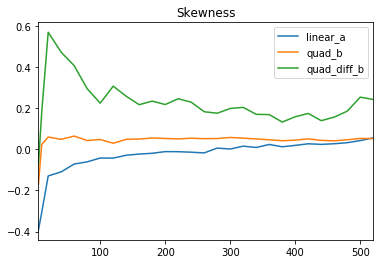

In [10]:
opt_params.iloc[:, [0, 3, 7]].plot()
plt.title('Skewness');

#### Term structure of kurtosis

Text(0.5, 1.0, 'Kurtosis')

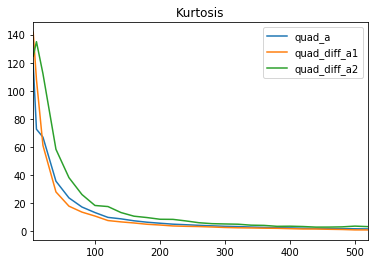

In [12]:
opt_params.iloc[:, [2, 5, 6]].plot()
plt.title("Kurtosis")

#### Compare estimated density with empirical density

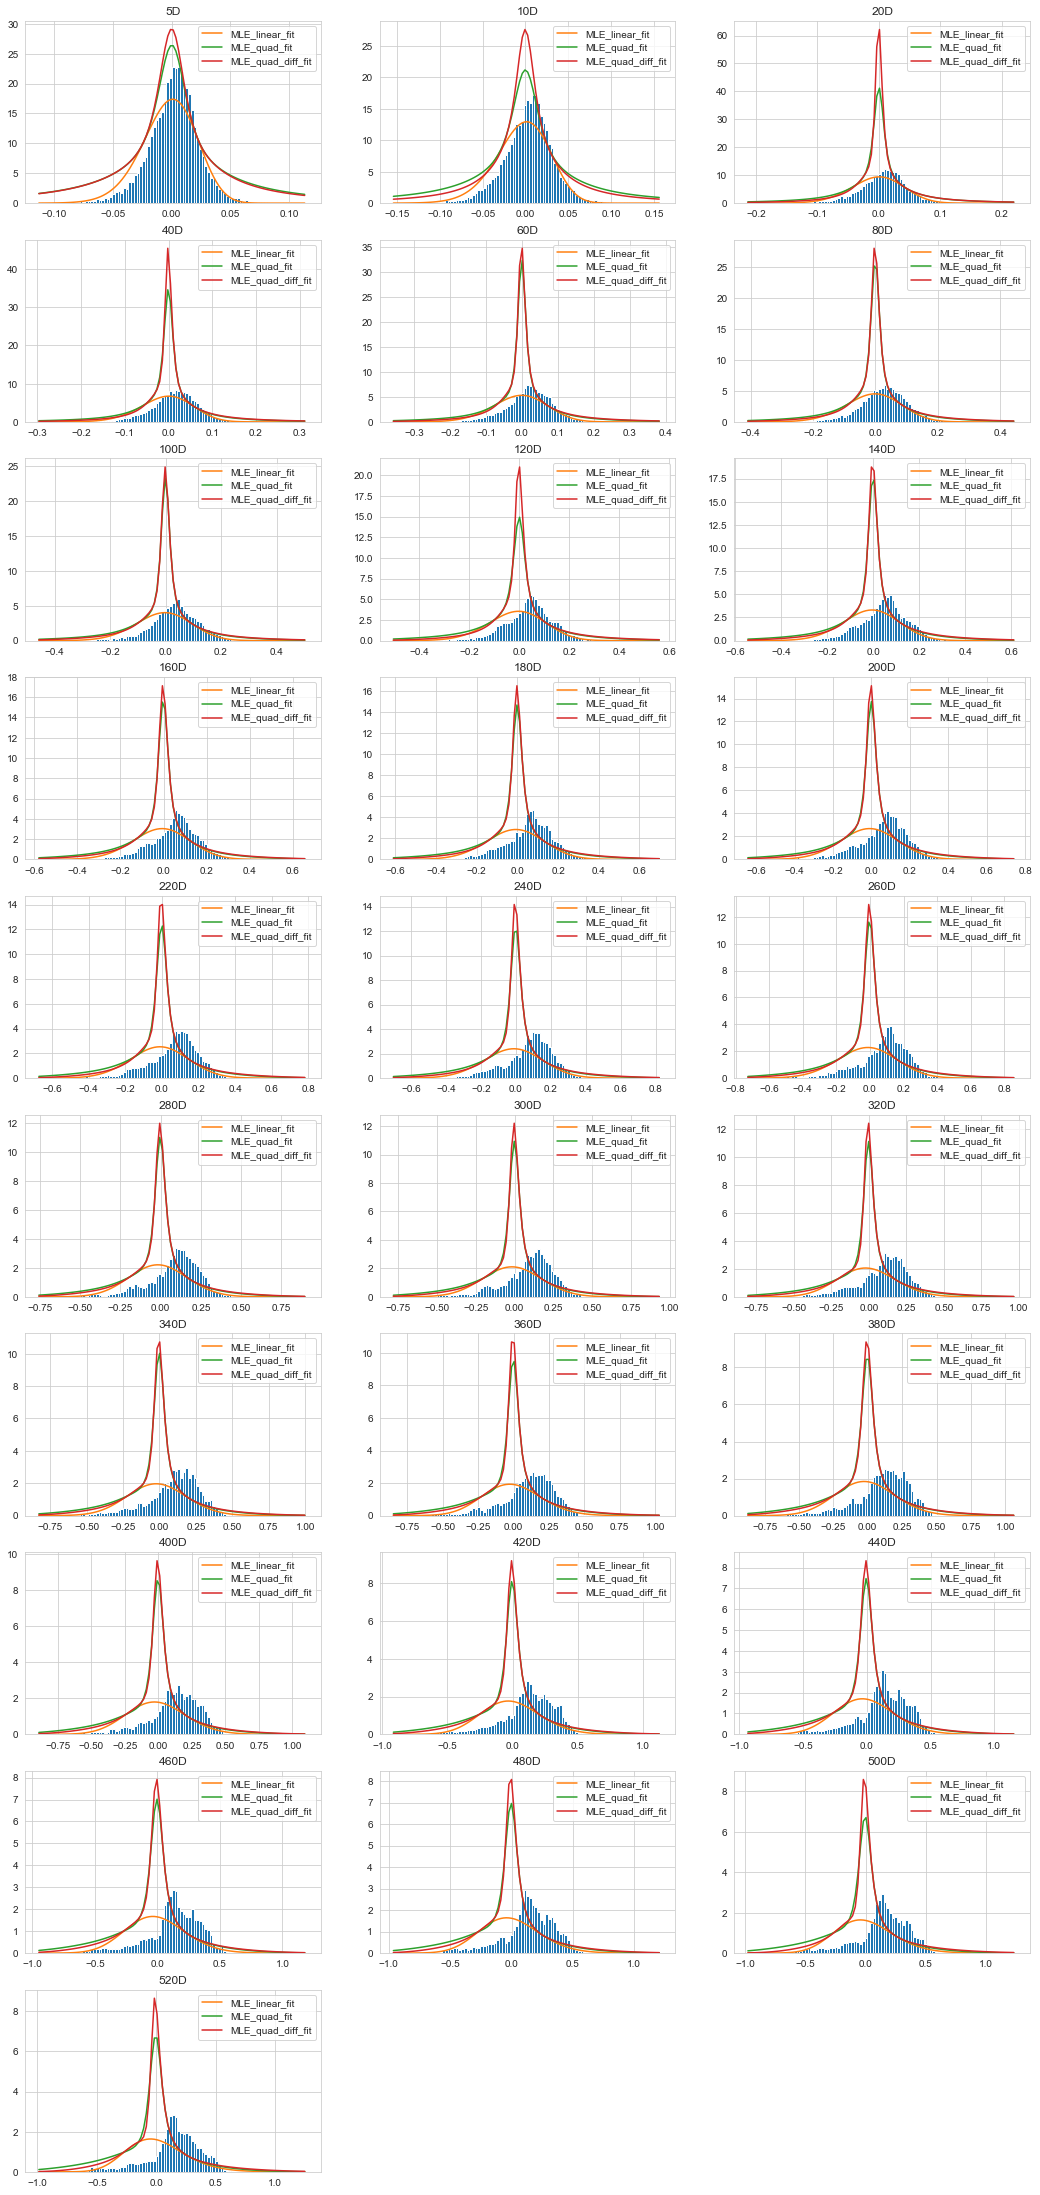

In [152]:
num_window = len(terms)
fig = plt.figure(figsize=(18, num_window*4))
index = 1
for term_str, term_day in terms.items():
    test = pd.DataFrame()
    plt.subplot(num_window, 3, index)
    full_series = df['mean_'+term_str].dropna()
    avg, std = full_series.mean(), full_series.std()
    r_sample = [round(elem, 4) for elem in np.arange(avg-5*std, avg+5*std, 0.1*std)]
    bins = np.linspace(avg-5*std, avg+5*std, 100)
    scale = 100
    test['r'] = r_sample
    params = (full_result.loc[term_day]).values.tolist()
    plt.hist(full_series, bins=bins, density=True)
    test['MLE_linear_fit'] = [round(calc_density(x=elem, r=0, T=term_day/260, 
                                                sigma=sigma_func_linear(elem, params[0], params[1]), delta_x=0.001), 4) 
                                 for elem in test['r']]
    test['MLE_quad_fit'] = [round(calc_density(x=elem, r=0, T=term_day/260, 
                                                  sigma=sigma_func_quad(elem, params[2], params[3], params[4]),
                                                  delta_x=0.001), 4) 
                               for elem in test['r']]
    test['MLE_quad_diff_fit'] = [round(calc_density(x=elem, r=0, T=term_day/260, 
                                                  sigma=sigma_func_diff_quad(elem, params[5], params[6], params[7], params[8]),
                                                  delta_x=0.001), 4) 
                               for elem in test['r']]
    plt.plot(test['r'], test['MLE_linear_fit'])
    plt.plot(test['r'], test['MLE_quad_fit'])
    plt.plot(test['r'], test['MLE_quad_diff_fit'])
    plt.legend()
    plt.title(term_str)
    index += 1

#### Estimated Volatility Curve

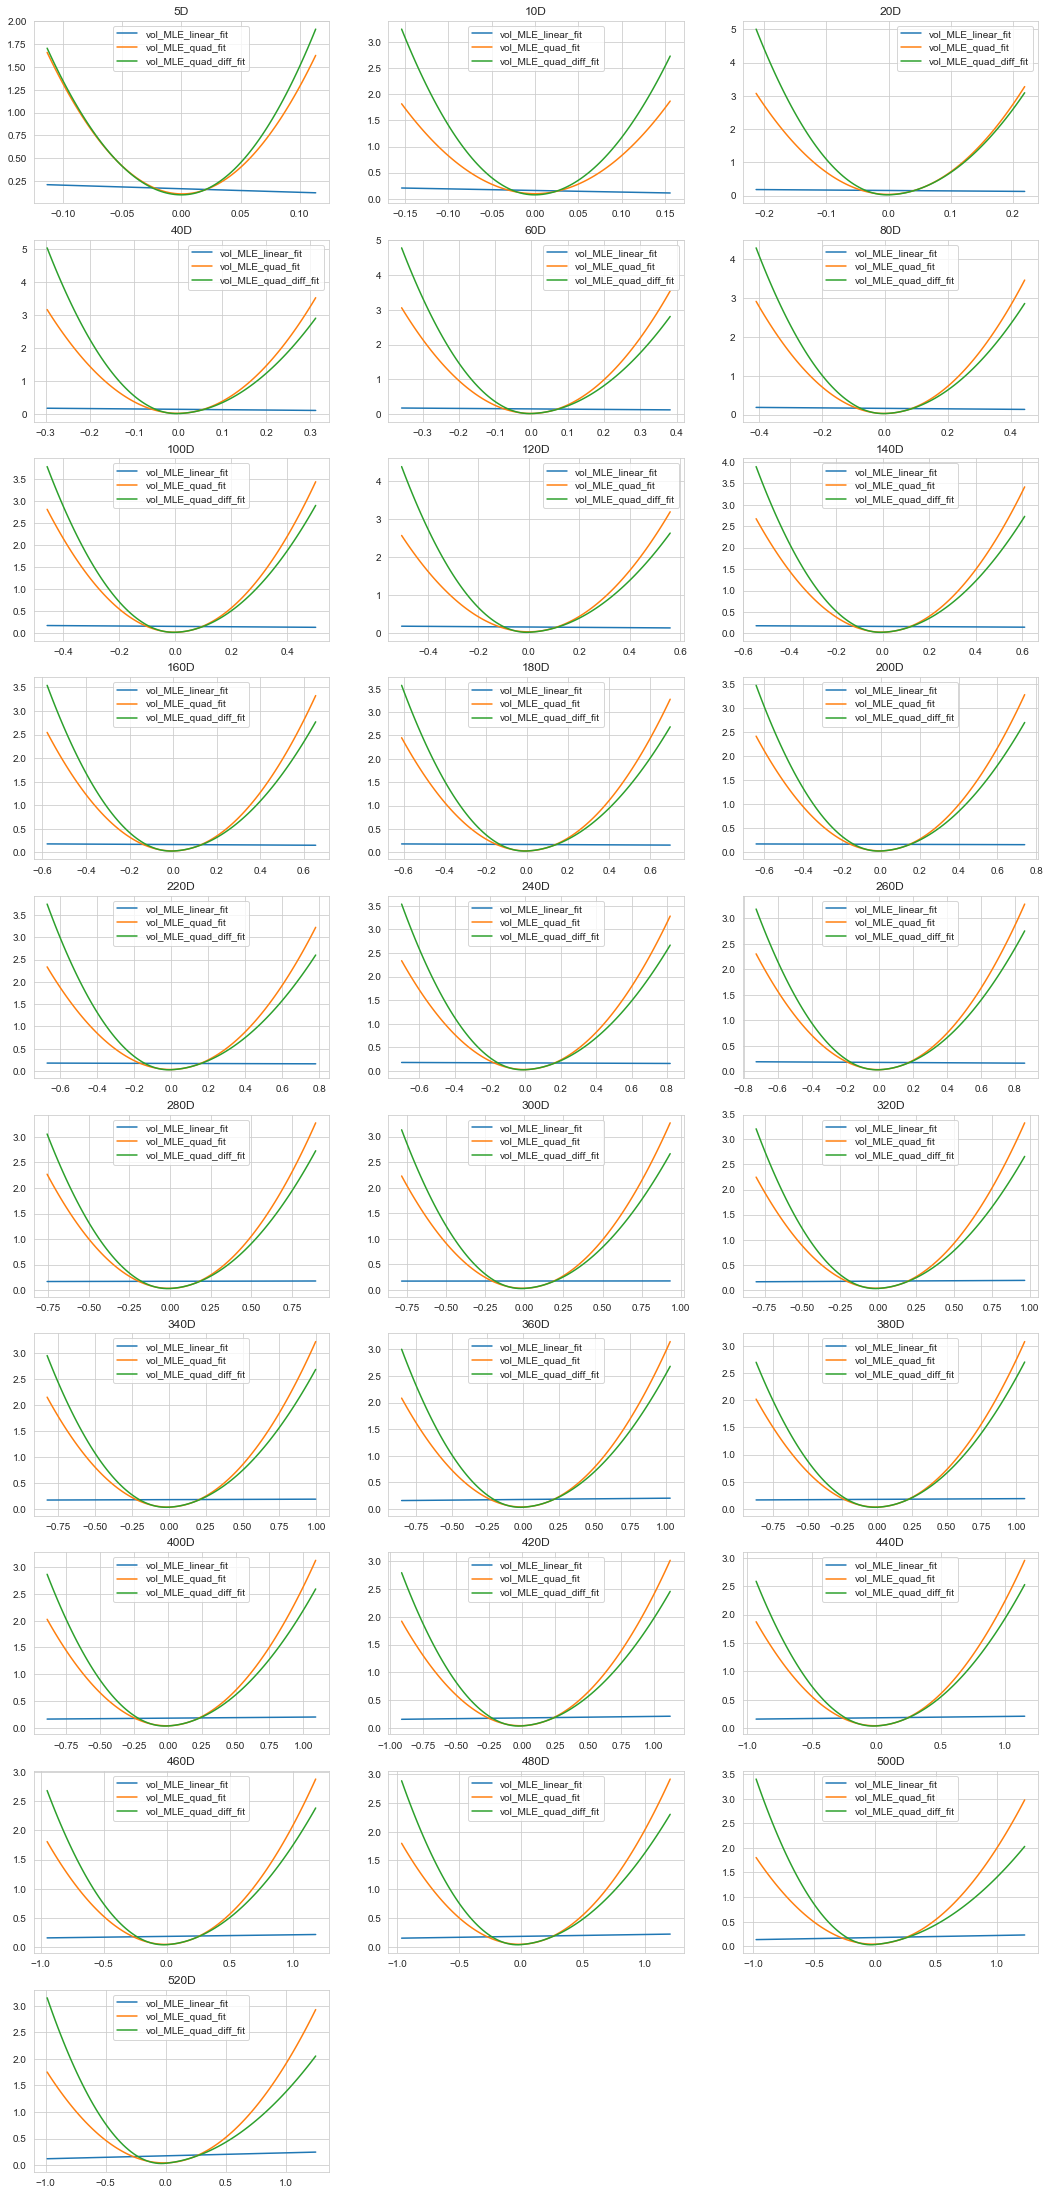

In [153]:
### Estimated volatility curvenum_window = len(terms)
fig = plt.figure(figsize=(18, num_window*4))
index = 1
for term_str, term_day in terms.items():
    test = pd.DataFrame()
    plt.subplot(num_window, 3, index)
    full_series = df['mean_'+term_str].dropna()
    avg, std = full_series.mean(), full_series.std()
    r_sample = [round(elem, 4) for elem in np.arange(avg-5*std, avg+5*std, 0.1*std)]
#     bins = np.linspace(avg-5*std, avg+5*std, 100)
#     scale = 100
    test['r'] = r_sample
    params = (full_result.loc[term_day]).values.tolist()
#     plt.hist(full_series, bins=bins, density=True)
    test['vol_MLE_linear_fit'] = [sigma_func_linear(elem, params[0], params[1]) for elem in test['r']]
    test['vol_MLE_quad_fit'] = [sigma_func_quad(elem, params[2], params[3], params[4]) for elem in test['r']]
    test['vol_MLE_quad_diff_fit'] = [sigma_func_diff_quad(elem, params[5], params[6], params[7], params[8]) for elem in test['r']]
    plt.plot(test['r'], test['vol_MLE_linear_fit'])
    plt.plot(test['r'], test['vol_MLE_quad_fit'])
    plt.plot(test['r'], test['vol_MLE_quad_diff_fit'])
    plt.legend()
    plt.title(term_str)
    index += 1

#### Analyze parameters with resampling

In [ ]:
term_day = 20
MLE_linear20D=[]
for i in range(20):
    full_series = df['20D_return'].dropna()
    keep_rows = list(range(i, len(full_series), term_day))
    r_series = full_series.iloc[keep_rows]
    method = 'linear'

    # obj_MLE = minimize(obj_func_likelihood, (-1, 1), args=(r_series, term_day, method), method='L-BFGS-B')
    obj_MLE = minimize(obj_func_log_likelihood, (-1, 1), args=(r_series, term_day, method), method='SLSQP', options={'disp': True})
    MLE_linear20D.append(obj_MLE.x)
    print(obj_MLE)

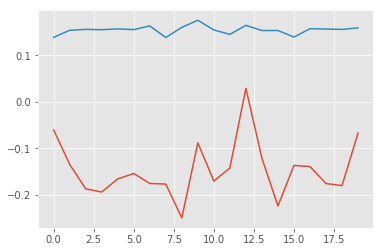

In [16]:
plt.style.use('ggplot')
plt.plot(range(20),MLE_linear20D)